In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [11]:
%%html

<a href="https://jy2014.github.io/EpilepsyPrediction/Home.html" target="_self">Back to the Home Page</a>

# Chapter 3. Predicting Epilepsy Status #

_________________________
<font size="3"><p>After imputing missing values, we built classification models to predict epilepsy status using the survey data. We tuned parameters for <b> Linear Discriminant Analysis (LDA), Quadratic Discriminant Anlysis (QDA), Weighted Logistic Regression and Random Forest </b>. Because the dataset is <b>highly imbalanced</b>, with the ratio of epilepsy to non-epilepsy respondents of 1 : 100, we tuned the class weight or priors in addition to regularization parameters, and used the <b> F1 score </b> instead of the overall accuracy rate to evaluate our models.</p>
<p></p>
The model selection procedure and results are shown in details below. </font>

In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import sklearn.preprocessing as Preprocessing
from sklearn.preprocessing import StandardScaler as Standardize
from sklearn import metrics
from sklearn import ensemble
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from itertools import combinations
from sklearn.linear_model import LogisticRegression as Log
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image
%matplotlib inline

<font size = '3'>
- [3.1. Read the imputed dataset](#3.1.Read-the-imputed-dataset)
- [3.2. Model Selection](#3.2.Model-Selection)
- [3.3. Model Comparison](#3.3.Model-Comparison)
- [3.4. Feature Importance](#3.4.Feature-Importance)
___

*** please click the button on top of the page to view the code ***

___

## 3.1.Read the imputed dataset ##
<p></p>
<font size = "3">We read the imputed data set from Part 2. We removed respondents who did not provide information to the epilepsy questions, and one-hot encoded the categorical variables.</font>  

In [4]:
# Read dataset with imputated dataset (Random_Forest)
df_final = pd.read_csv('imputed_PovertyLevel_RF.csv')

# Drop the first two columns as well as ID number, as it is of no relevance
df_final = df_final.drop(df_final.columns[[0, 1, 2]], axis=1)
# remove the respondents missing epilepsy information
df_final = df_final[df_final.K2Q42A != 6]
df_final = df_final[df_final.K2Q42A != 7]
# extract epilepsy status as y
df_y = df_final['K2Q42A']
# remove other epilepsy related info from the predictors
df_x = df_final.drop(['K2Q42A','K2Q42B','K2Q42C'], 1)

# Read categorical dataset, and then apply one-hot encoder
df_cat = pd.read_csv('Categorical_Column_Names_wState.csv', header = None)
# Read categorical dataset
cat = df_cat.iloc[:, 1]
cat = np.array(cat)
categorical_names = cat

# remove epilepsy related names
categorical_names = categorical_names[categorical_names != 'K2Q42A']
categorical_names = categorical_names[categorical_names != 'K2Q42B']
categorical_names = categorical_names[categorical_names != 'K2Q42C']

# Apply one hot endcoing
DF_for_impute_dummies = pd.get_dummies(df_x, columns = categorical_names)

# reorganize the variables
df_x = DF_for_impute_dummies
df_y = df_y
df_x_array = np.array(df_x)
df_y_array = np.array(df_y)

___
## 3.2.Model Selection ##
<p></p>
<font size = "3"><p>To accurately predict epilepsy status in our imbalaned dataset, we need to consider differnet types of classification errors. Because a naive classifier that says everyone is healthy would have a high accuracy rate, we have to consider a metric other than overall accuracy. So, we evaluated our models based on <b> F1 score </b>, which gives a combined score based on precision and recall. </p>
<p></p>
$$ F1 = \frac{2 \times Precison \times Recall}{Precision + Recall} $$

<p>After fitting several models using cross validation, we found out that <b> weighted logistic regression</b> ( C = 0.001, Class_weight = {0:1, 1:10.0} ) gave us the highest F1 score, around 0.26. Moreover, the accuracy rate was also very high at 0.98. Considering that this is a survey dataset with thousands of features, we were satisfied with the model we got.</p></font>

* <font size = "4"> <b>Baseline Models</b></font>
<p></p>
    <font size = "3"><p>If observations are randomly assigned to the epilepsy or non-epilepsy groups, the overall accuracy rate is 0.5, and the F1 score is 0.02. If all the observations are classified into the non-epilepsy group, the overall accuracy rate is 0.99, but F1 score is almost zero. The result is consistent with the fact that the classes are highly imbalanced. Given our goal of detecting epilepsy patients, F1-score is a better measure than the overall accuracy rate. </p></font>

In [6]:
### randomly assign classes
#y_pred = np.random.binomial(1, 0.5, 90539)

## accuracy
# print "accuracy: ", np.mean(y_pred == df_y_array)
# print "F1:", metrics.f1_score(df_y_array, y_pred)
# print "precision: ", metrics.precision_score(df_y_array, y_pred)
# print "recall: ", metrics.recall_score(df_y_array, y_pred)

### simple non-weighted logistic regression
#y_pred = np.loadtxt("y_pred_simplelog.txt", delimiter = ',').reshape((90539, 1))

## accuracy
# print "accuracy: ", np.mean(y_pred == df_y_array)
# print "F1:", metrics.f1_score(df_y_array, y_pred)
# print "precision: ", metrics.precision_score(df_y_array, y_pred)
# print "recall: ", metrics.recall_score(df_y_array, y_pred)
model = Log()
skf = StratifiedKFold(n_splits = 5, shuffle = True)
grid_model = GridSearchCV(model, param_grid = {}, cv  = skf, scoring = 'f1')
grid_model.fit(df_x_array, df_y_array)
log_baseline = grid_model.best_estimator_
y_pred = cross_val_predict(log_baseline, df_x, df_y, cv = skf) 

//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


* <font size = "4"> <b>Linear Discriminant Analysis (LDA) </b></font>
<p></p>
    <font size = "3"><p>We performed Linear Discriminant Analysis (LDA) using Stratified k-Fold cross-validation. Stratified k-Fold preserves the class proprtions in each fold, and prevents the case where a fold does not contain any positive samples. The priors were tuned to accommodate the class imbalance. The best model were chosen based on the F1 score, which generated an overall accuracy rate of 0.98, F1 score of 0.25. </p></font>

In [8]:
# LDA
model = LDA()

# five fold stratified CV
skf = StratifiedKFold(n_splits = 5, shuffle = True)
# tune priors
weights = np.concatenate((np.arange(2,10,1), np.logspace(1,5,5)), axis = 0)
prior_list = [np.asarray([1-1/weights[i], 1/weights[i]]) for i in range(len(weights))]

# tune the model
grid_model = GridSearchCV(model, param_grid = {'priors': prior_list}, cv  = skf, scoring = 'f1')
grid_model.fit(df_x_array, df_y_array)
lda = grid_model.best_estimator_

In [9]:
### parameters of the best model were recorded for future use
# because runing the model selection code again will TAKE A LONG TIME
###

# the resulted best model
lda = LDA(priors=np.asarray([9.99900e-01,   1.00000e-04]), shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

# predict using CV predict
skf = StratifiedKFold(n_splits = 5, shuffle = True)
y_pred = cross_val_predict(lda, df_x, df_y, cv = skf) 

# print metrics.f1_score(df_y, y_pred)
# metrics.confusion_matrix(df_y, y_pred)

* <font size = "4"> <b>Quadratic Discriminant Analysis (QDA)</b></font>
<p></p>
    <font size = "3"><p>We performed Quadratic Discriminant Analysis (QDA) using Stratified k-Fold Cross-Validation. The regularization parameter and priors were tuned to accommodate the class imbalance and large number of predictors. The best model was selected based on F1 score. The best QDA model generated an accuracy rate of 0.12 and F1 score of 0.02. The low accuracy and F1 score is due to a high recall of 0.93.</p></font>

In [29]:
# QDA
model = QDA()

# five fold stratified CV
skf = StratifiedKFold(n_splits = 5, shuffle = True)
# tune priors
weights = np.concatenate((np.arange(2,10,2), np.logspace(1,5,5)), axis = 0)
prior_list = [np.asarray([1-1/weights[i], 1/weights[i]]) for i in range(len(weights))]
# tune regularization parameter
C = range(-4, 5, 1)
c = np.power(10.0, C)

# tune the model
grid_model = GridSearchCV(model, param_grid = {'priors': prior_list, 'reg_param': c},
                          cv  = skf, scoring = 'f1')
grid_model.fit(df_x_array, df_y_array)
qda = grid_model.best_estimator_

In [10]:
### parameters of the best model were recorded for future use
# because runing the model selection code again will TAKE A LONG TIME
###

# the resulted best model
qda = QDA(priors=[  9.99990e-01,   1.00000e-05],
               reg_param=1.0, store_covariances=False, tol=0.0001)
# predict using CV predict
y_pred = cross_val_predict(qda, df_x, df_y, cv = skf) 

# print metrics.f1_score(df_y, y_pred)
# metrics.confusion_matrix(df_y, y_pred)

//anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


* <font size = "4"> <b> Logistic Regression (with subsampling)</b></font>
<p></p>
    <font size = "3"><p>We performed weighted logistic regression. We tuned several parameters for logistic regression, including the regularization parameter $C$, class weights and penalty types (L1 or L2). 
When fitting the logistic regression to our large dataset (which includes more than 90,000 entries and 1,500 one hot encoded features), we found that the program had a <b> long computation time </b>. In order to allocate our time and computational capacity more efficiently, we <b> randomly selected a subsample of the non-epilepsy group </b> to use in the analysis. We subsampled with different ratios of non-epilepsy to epilepsy respondents, including 10:1 and 20:1, and combined this set with the epilepsy group to perform model selection. The optimal values of the parameters were selected based on cross-validation, and then the <b> cross-validation accuracy of the selected model was evaluated on the entire dataset </b>. The best logistic regression model generates an F1 score of 0.26 and an overall accuracy of 0.97.</p></font>

In [30]:
### Because performing Logistic regression on the entire dataset TAKES A LONG TIME
# subsets of the healthy people were sampled and combined with the epi patients 
# the ratio of health to epi is 20:1
# models were selected using this subsampled dataset
###

random shuffle the rows
n = df_x_array.shape[0]
perm = range(n)
np.random.shuffle(perm)

x = df_x_array[perm]
y = df_y_array[perm]

# Resubsample 20:1 first
# extract epilepsy patients data
x_epi = x[y==1]
y_epi = y[y==1]
# healthy patients data
x_health = x[y==0]
y_health = y[y==0]

# sample 19340 healthy patients (if healthy : epilepsy = 20 : 1)
# sample 9670 healthy patients (if healthy : epilepsy = 10 : 1)
# the data has already been shuffled
x_health = x_health[:19341]
y_health = y_health[:19341]

# combine the epilepsy and sampled healthy data
x2 = np.concatenate((x_epi, x_health), axis = 0)
y2 = np.concatenate((y_epi, y_health), axis = 0)

# shuffle the combined data
n3 = x2.shape[0]
perm2 = range(n3)
np.random.shuffle(perm2)

x2 = x2[perm2]
y2 = y2[perm2]

# CV to tune the parameters, including C, 'l2/l1', Class_weight
model = Log()
skf = StratifiedKFold(n_splits = 5, shuffle = True)
C = range(-4, 5, 1)
c = np.power(10.0, C)
weights = np.logspace(1,5,5)
weight_list_dict = [{0:1, 1: weights[i]} for i in range(len(weights))]
grid_model = GridSearchCV(model, param_grid = {'C': c, 'class_weight': weight_list_dict}, 
                          cv  = skf, scoring = 'f1')
grid_model.fit(x2, y2)
log = grid_model.best_estimator_

In [11]:
### parameters of the best model were recorded for future use
# because runing the model selection code again will TAKE A LONG TIME
###

# the resulted best model
log = Log(C = 0.001, class_weight = {0:1, 1:10})

y_pred = cross_val_predict(log, df_x, df_y, cv = skf) 

# print metrics.f1_score(df_y, y_pred)
# metrics.confusion_matrix(df_y, y_pred)

* <font size = "4"> <b>Random Forest</b></font>
<p></p>
    <font size = "3"><p>We also implemented a random forest classifier using cross-validation. The tuned parameters include 'number of trees', 'class weights' and 'max_depth', and the best model was selected based on F1 scores. The best Random Forest model had an overall accuracy rate of 0.98, with F1 score to be 0.19. The F1 score was lower than that of the best weighted logistic regression.

In [33]:
skf = StratifiedKFold (n_splits = 3, shuffle = True)

model = ensemble.RandomForestClassifier(n_estimators = 10)
#n_trees = np.arange(10, 100, 20)  # Trees and depth are explored on an exponentially growing space,
depths = np.arange(10, 30, 5).astype(int)   # since it is assumed that trees and depth will add accuracy in a decaying fashion.
weights = np.logspace(1,4,4).astype(int)
weight_list_dict = [{0:int(1), 1: weights[i]} for i in range(len(weights))]

grid_model = GridSearchCV(model , n_jobs = 5, param_grid = {'class_weight': weight_list_dict, 'max_depth': depths}, 
                          cv  = skf, scoring = 'f1')
grid_model.fit(df_x_drop, df_y_drop)
best_forest = grid_model.best_estimator_

#print best_forest

best_forest_description = str(best_forest.get_params)
f = open ('RandomForest_best_params'+'.p', 'wb')
pickle.dump([best_forest_description], f)
f.close()

y_pred = cross_val_predict(best_forest, df_x_drop, df_y_drop, cv = skf)
f = open ('RandomForest_y_pred'+'.p', 'wb')
pickle.dump([y_pred], f)
f.close()

# print 'F1 score CV:', f1_score (df_y_drop, y_pred)

# print 'F1 score CV: ', cross_val_score(best_forest, df_x_drop, df_y_drop, cv=skf, scoring = 'f1')
# print 'R2 score CV: ', cross_val_score(best_forest, df_x_drop, df_y_drop, cv=skf)

In [12]:
### parameters of the best model were recorded for future use
# because runing the model selection code again will take a long time
###

# the resulted best model
rf = ensemble.RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 100},
                                     criterion='gini', max_depth=15, max_features='auto')

y_pred = cross_val_predict(log, df_x, df_y, cv = skf) 

# print metrics.f1_score(df_y, y_pred)
# metrics.confusion_matrix(df_y, y_pred)

___
## 3.3.Model Comparison ###

<font size="3">After the best parameters were selected for Linear Discriminant Analysis (LDA), Quadratic Discriminant Analysis (QDA), Logistic Regression and Random Forest. The results from all the models were compared, and the best model was selected based on the highest F1 score. The regularized weighted logistic regression provided the highest F1 score of 0.26 as well as a comparabily high accuracy rate of 0.97. Therefore, <b>the regularized weighted logistic regression was selected to be the best model for the prediction of epilepsy diagnosis.</b>
<p></p>
<img src="https://cloud.githubusercontent.com/assets/9686980/21193011/a9d49ab2-c1f8-11e6-8201-8fc004795f69.JPG" alt="Model result 1" width = 400 />

<p><font size="3"><b> ROC plot of the models</b></font></p>
<p><font size="3"> Receiver Operating Characteristic (ROC) curves of the models were plotted. ROC is a graphical plot that illustrates the performance of a classifier system as the discrimination threshold varies. The curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at different threshold values. The ROC curve hugging the upper left corner suggests that the model performs well on the classification. </p></font>

In [15]:
def ROC_plot (y_test, y_pred, col, name, ax):
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    
    ax.plot(false_positive_rate, true_positive_rate, color = col, label= name + ':AUC = %0.2f'% roc_auc)
    ax.plot([0,1],[0,1],'r--')

In [19]:
# prepare the best models
lda = LDA(priors=np.asarray([9.99900e-01,   1.00000e-04]), shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
qda = QDA(priors=[  9.99990e-01,   1.00000e-05],
               reg_param=1.0, store_covariances=False, tol=0.0001)
log = Log(C = 0.001, class_weight = {0:1, 1:10})

rf = ensemble.RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 100},
                                     criterion='gini', max_depth=15, max_features='auto')

# split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(df_x_array, df_y_array, test_size=0.3)

# train each model on the training set
lda.fit(x_train, y_train)
qda.fit(x_train, y_train)
log.fit(x_train, y_train)
rf.fit(x_train, y_train)

# extract the probability on the testing set
proba_log = log.predict_proba(x_test)[:, 1]
proba_lda = lda.predict_proba(x_test)[:, 1]
proba_qda = qda.predict_proba(x_test)[:, 1]
proba_rf = rf.predict_proba(x_test)[:, 1]

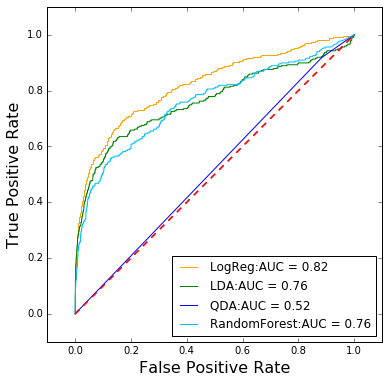

In [27]:
# plot ROC of the models
color = ['orange','g', 'b','deepskyblue']
names = ['LogReg', 'LDA', 'QDA', 'RandomForest']


fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111) 

ROC_plot(y_test, proba_log, color[0], names[0], ax)
ROC_plot(y_test, proba_lda, color[1], names[1], ax)
ROC_plot(y_test, proba_qda, color[2], names[2], ax)
ROC_plot(y_test, proba_rf, color[3], names[3], ax)
    
plt.legend(loc='lower right')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate', fontsize = 16)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.show()

___
## 3.4.Feature Importance ###
<p><font size="3"> Based on the comparison above, we decided examine important features in the weighted logistic regression model. Examining the coefficients for each feature in this model may help us identify risk factors for epilespy. However, the <b> top-ranked features in the list are probably caused by epilepsy </b> instead of being able to predict epilepsy, reflecting the <b> limitations of our dataset as a single-point observation </b>. 


Examples of the top-ranked predictors include:
 </p>

| Rank          | Question Topic           
| ------------- |:-------------
| 1             | General Health Quality
| 2             | Presence of Chronic Health Conditions
| 3             | Prescription Medication
| 4             | Ever Diagnosed with Developmental Delay
| 5             | Individualized Education Program
| 6             | Learning Disability
| 7             | Individualized Education Program
| 8             | Developmental Delay Severity
| 9             | Current Developmental Delay
| 10            | Learning Disability Severity

___

<p></p>
<p><font size="3"><b> Epilepsy is known to cause developmental delays and learning disabilities, as well as bad general health status.</b> Therefore, the important predictors identified in our model might not be useful in a real world context. To combat this, we <b> tried manually going through the top 200 features and identifying predictors that are probably not caused by epilepsy, and considered re-running different models using these predictors.</b> However, because our data are highly multicollinear, re-running these models based on a hand-selected predictor set may not give us interpretable features due to correlation between features. 

<b>Therefore, our model may not be useful to predict future epilepsy status in a real-world context. </b></font></p> 

### Our next step was to address whether we could predict the quality of life in epilepsy patients.

In [35]:
log.fit(df_x_array, df_y_array)
coef = log.coef_
coef_list = coef[0]

# As we want to compare the absolute value of coefficients here, we need to change negative ones to be positive
coef_change = []
for i in range(len(coef_list)):
    if coef_list[i] < 0:
        coef_change.append(-coef_list[i])
    else:
        coef_change.append(coef_list[i])
# Get the index from large to small
a = np.array(coef_change)
index = np.argsort(-a)
# Pick the top 50 highest index, to see what the features are the most important
index_top_50 = index[:50]
# Now go back to find what the corresponding highest-rank features are.
features_names = DF_for_impute_dummies.columns.values
features_names_top_50 = features_names[index_top_50]

In [3]:
%%html
<a href="https://jy2014.github.io/EpilepsyPrediction/Imputation.html" target="_self">Chapter 2. Data Imputation</a>

In [2]:
%%html
<a href="https://jy2014.github.io/EpilepsyPrediction/QualityOfLife.html" target="_self">Chapter 4. Quality of Life</a>

In [4]:
%%html
<a href="https://jy2014.github.io/EpilepsyPrediction/Home.html" target="_self">Back to the Home Page</a>